# 1 导入及数据获取 

In [1]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV 
from sklearn.datasets import fetch_lfw_people 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.decomposition import PCA 
from sklearn.svm import SVC 
  
import numpy as np 

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=0.5) 

**文件结构：**

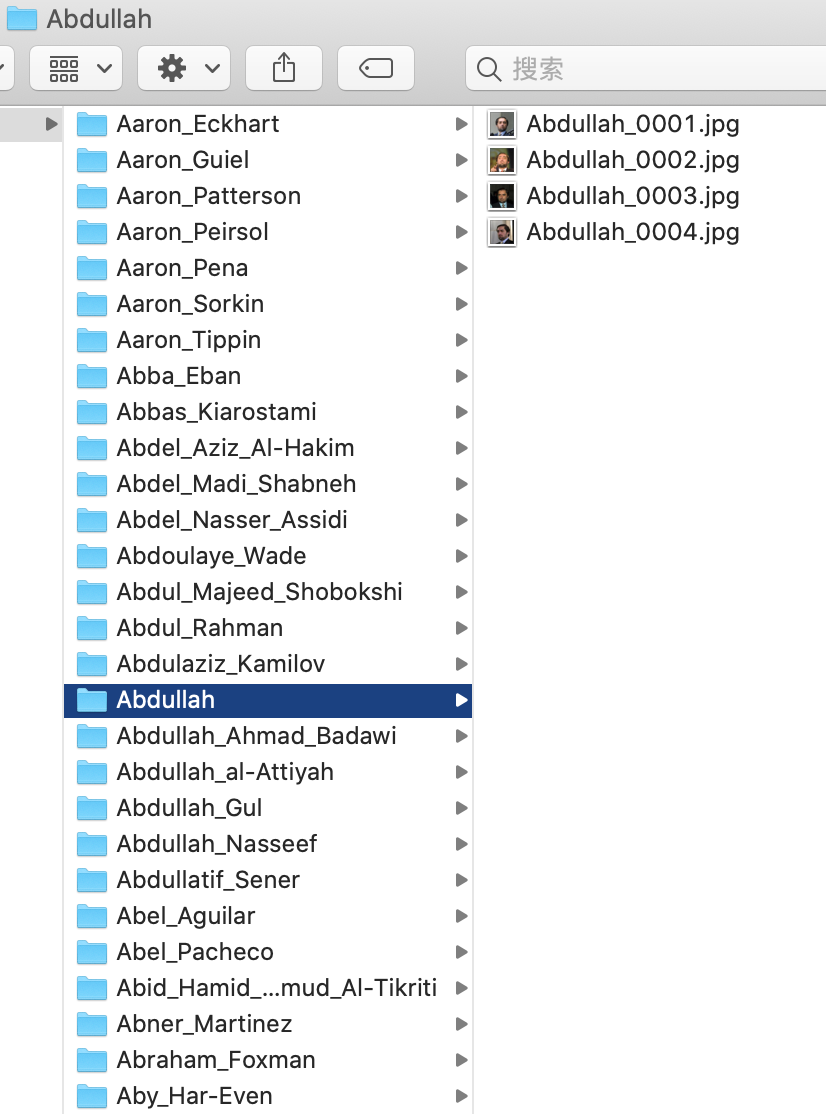

In [3]:
from IPython.display import Image
Image(filename='文件结构.png',width=400)

- 每个人有几张照片，根据min_faces_per_person选择每个人的最低人脸数量

In [4]:
lfw_people.data.shape

(3023, 2914)

In [5]:
lfw_people.images.shape

(3023, 62, 47)

# 2 定义变量及函数

In [6]:
# introspect the images arrays to find the shapes (for plotting) 
n_samples, h, w = lfw_people.images.shape 
X = lfw_people.data 
n_features = X.shape[1] 
y = lfw_people.target 
target_names = lfw_people.target_names 
n_classes = target_names.shape[0] 

In [7]:
print("数据量:% d" % n_samples) 
print("特征量:% d" % n_features)   # 与照片清晰度设置相关
print("人脸数量:% d" % n_classes) 

数据量: 3023
特征量: 2914
人脸数量: 62


In [18]:
def plot_faces(images, titles, h, w, n_row = 4, n_col = 10): 
    '''
    打印images中的前n_row * n_col张人脸
    '''
    plt.figure(figsize =(1.8 * n_col, 2.4 * n_row)) 
    plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =.90, hspace =.35) 
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1) 
        plt.imshow(images[i].reshape((h, w)), cmap = plt.cm.gray) 
        plt.title(titles[i], size = 12) 
        plt.xticks(()) 
        plt.yticks(()) 

# Generate true labels above the images 
def true_title(Y, target_names, i): 
    true_name = target_names[Y[i]].rsplit(' ', 1)[-1] 
    return 'True Name: % s' % (true_name) 

# 3 原始脸 

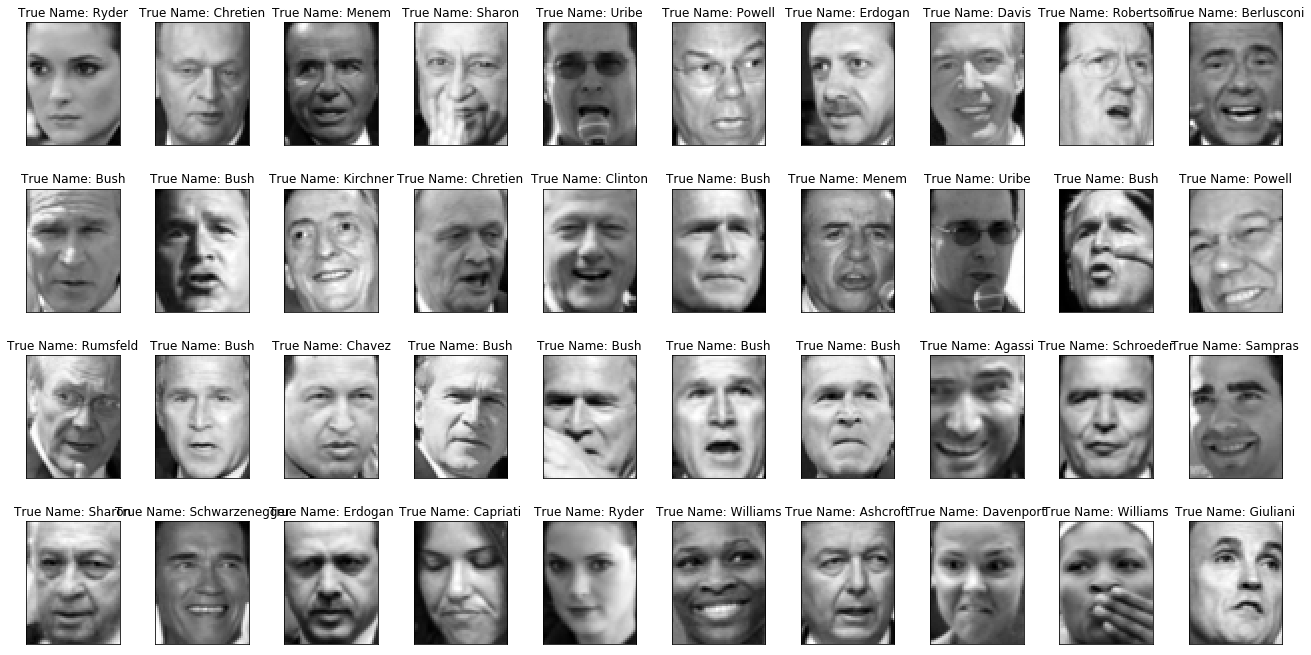

In [9]:
true_titles = [true_title(y, target_names, i) for i in range(y.shape[0])] 
plot_faces(X, true_titles, h, w) 

# 4 特征脸

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42) 
print("训练集脸数:% d｜测试集脸数:% d" %(y_train.shape[0], y_test.shape[0])) 

训练集脸数: 2267｜测试集脸数: 756


In [11]:
n_components = 150
pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train) 
eigenfaces = pca.components_.reshape((n_components, h, w)) 
X_train_pca = pca.transform(X_train) 
X_test_pca = pca.transform(X_test) 

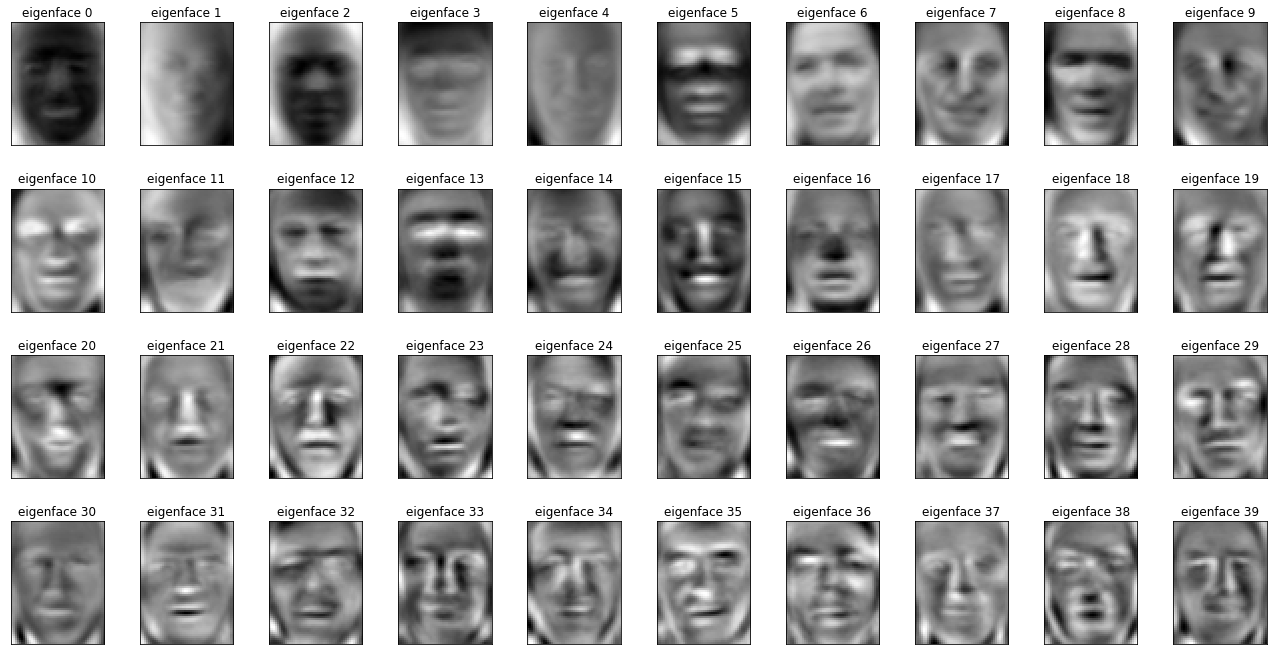

In [21]:
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_faces(eigenfaces, eigenface_titles, h, w)

plt.show()

# 5 核方法的支持向量机预测

## 5.1 参数搜索

In [22]:
param_grid = {'C': [5e3, 1e4, 5e4],
              'gamma': [0.0005, 0.001, 0.005, 0.01]}
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

In [23]:
clf = clf.fit(X_train_pca, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Best estimator found by grid search:
SVC(C=5000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.001,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


## 5.2 预测

In [14]:
# 测试集表现
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

         Alejandro Toledo       0.78      0.58      0.67        12
             Alvaro Uribe       0.71      0.56      0.63         9
          Amelie Mauresmo       0.60      0.30      0.40        10
             Andre Agassi       0.36      0.40      0.38        10
           Angelina Jolie       0.25      0.17      0.20         6
             Ariel Sharon       0.58      0.78      0.67        18
    Arnold Schwarzenegger       0.60      0.33      0.43        18
     Atal Bihari Vajpayee       0.60      0.43      0.50         7
             Bill Clinton       0.67      0.33      0.44         6
             Carlos Menem       0.50      0.60      0.55         5
             Colin Powell       0.74      0.77      0.76        71
            David Beckham       0.25      0.50      0.33         4
          Donald Rumsfeld       0.62      0.50      0.55        36
         George Robertson       1.00      1.00      1.00     

In [24]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[7 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 3 ... 0 0 1]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 2]]


## 5.3 测试结果

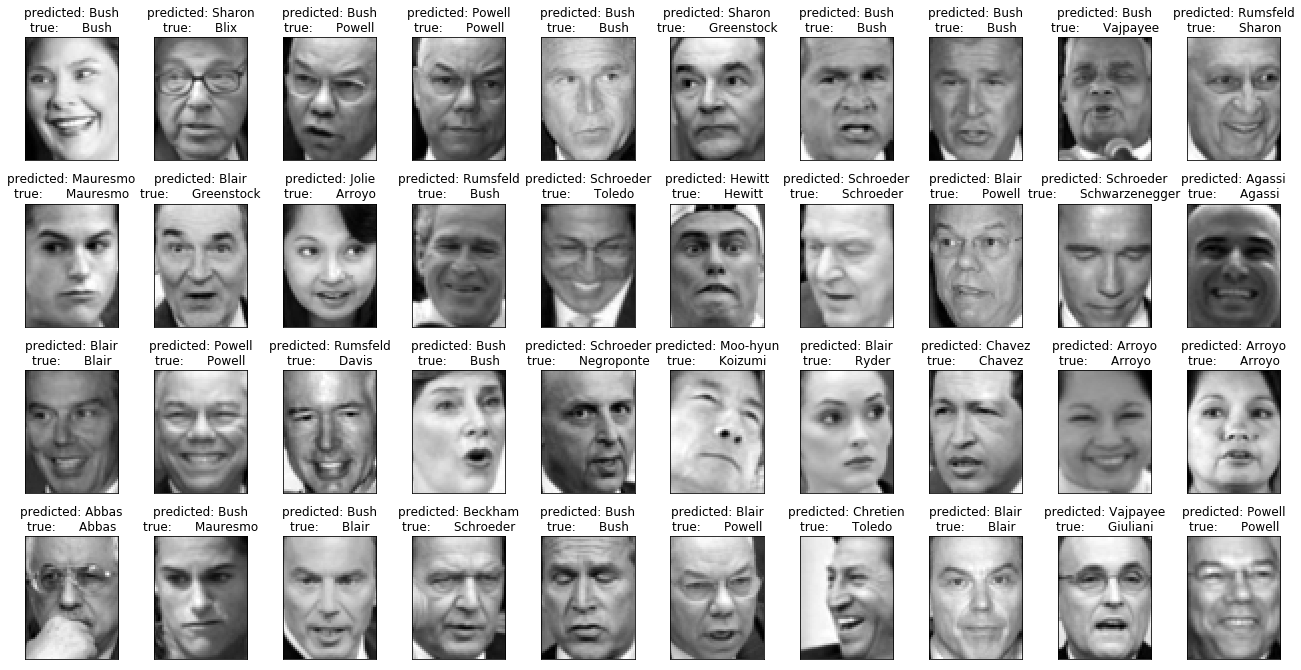

In [19]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_faces(X_test, prediction_titles, h, w)